In [1]:
import anndata, pickle, os, fnmatch, math, random
import scipy.stats as stats
import statistics as st
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator, LogLocator, LogFormatter, LogFormatterSciNotation, MaxNLocator
import matplotlib.patches as mpatches

In [2]:
'''IMPORTING NECESSARY FUNCTIONS FROM GENERAL FUNCTION FILE'''

%run GeneralFunctions.ipynb

# Calculation Functions Figure 5 

In [3]:
# Takes a list of sample comparisons and returns only those that are male vs. female
    # allSamples = list with lists of comparisons to make 
        # example format: [['condition of 1 and 2', 'sample1', 'sample2']['condition of 3 and 4', 'sample3', 'sample4']...]
def diffSexSampleLst(allSamples):
    diffSexLst = []
    for sampleLst in allSamples:
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]
        
        if not comaringSex(sample1_name, sample2_name):
            diffSexLst.append(sampleLst)
    
    return diffSexLst

In [4]:
# Adds DE scores to samples in a comparison list
    # comparisonLst = list with lists of comparisons to make 
        # example format: [['condition of 1 and 2', 'sample1', 'sample2']['condition of 3 and 4', 'sample3', 'sample4']...]
    # folderName = string of the folder name where the AnnData object you want to use are located in 
def addingDEToAllSamples(comparisonLst, folderName):
    
    # Getting list of samples that are male vs female comparisons
    diffSexLst = diffSexSampleLst(comparisonLst)
    
    for sampleLst in diffSexLst:
        condition = sampleLst[0]
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]

        fileName = f'{condition}_{sample1_name}_{sample2_name}'
        
        sampleObj = sc.read(f'F:/SampleData/{folderName}/{fileName}.h5ad')
        
        sampleObjWithDE = addingDEscore(sampleObj, 'sex', 'male', 'female')
        
        sampleObjWithDE.write(f'F:/SampleData/{folderName}/{fileName}.h5ad')

In [5]:
# Calculates Fold Change for Male vs. Female Nuclei 

def calculatingFoldChange(comparisonLst, folderName, savePath):
    foldChangeDict = {}
    
    diffSexLst = diffSexSampleLst(comparisonLst)
    
    for sampleLst in diffSexLst:
        # Getting Samples Info 
        condition = sampleLst[0]
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]  
        fileName = f'{condition}_{sample1_name}_{sample2_name}'
        
        # Reading Sample AnnData Object 
        sampleObj = sc.read(f'F:/SampleData/{folderName}/{fileName}.h5ad')

        # Seperating AnnData Objects into Male and Female Samples 
        male_obj = sampleObj[sampleObj.obs['sex'].isin(['male']),:]
        female_obj = sampleObj[sampleObj.obs['sex'].isin(['female']),:]
        
        # Getting Mean Gene Expression for Male Nuclei 
        male_geneExpression = male_obj.X.toarray()
        male_meanGeneExpression = list(np.mean(male_geneExpression, axis=0))

        # Getting Mean Gene Expression for Female Nuclei 
        female_geneExpression = female_obj.X.toarray()
        female_meanGeneExpression = list(np.mean(female_geneExpression, axis=0))
        
        # Iterating through each mean exp. and calculating fold change 
        for i in range(len(female_meanGeneExpression)):
            male_exp = male_meanGeneExpression[i]
            female_exp = female_meanGeneExpression[i]
            
            if male_exp == 0 and female_exp == 0:
                div = 1
            elif male_exp == 0 and female_exp != 0:
                div = 0.1 / female_exp
            elif male_exp != 0 and female_exp == 0:
                div = male_exp / 0.1
            else:
                div = male_exp / female_exp
        
            if fileName not in (foldChangeDict.keys()):
                foldChangeDict[fileName] = [div]
            else:
                foldChangeDict[fileName].append(div)
    
    with open(savePath, 'wb') as file:
        pickle.dump(foldChangeDict, file) 

In [6]:
def numberOfDEGenes(comparisonLst, folderName, male_savePath, female_savePath):
    male_deCountDict = {}
    female_deCountDict = {}
    
    diffSexLst = diffSexSampleLst(comparisonLst)
    
    for sampleLst in diffSexLst:
        # Getting Samples Info 
        condition = sampleLst[0]
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]  
        fileName = f'{condition}_{sample1_name}_{sample2_name}'
        dictName = f'{sample1_name}_{sample2_name}'
        
        # Reading Sample AnnData Object 
        sampleObj = sc.read(f'F:/SampleData/{folderName}/{fileName}.h5ad')
        clustLst = list(np.unique(sampleObj.obs['leiden_0.3']))
        sortedClustLst = sortClust(clustLst)
        
        for clust in sortedClustLst:
            clustObj = sampleObj[sampleObj.obs['leiden_0.3'].isin([clust]),:]
            
            maleCount = list(clustObj.obs['sex']).count('male')
            femaleCount = list(clustObj.obs['sex']).count('female')
            
            if maleCount > 1 and femaleCount > 1:
                # Calculating and adding DE score to each cluster object 
                clustObjWithDE = addingDEscore(clustObj, 'sex', 'male', 'female')

                lessThan = (clustObj.var[f'male_DE_Score'] > 20)
                greaterThan = (clustObj.var[f'female_DE_Score'] > 20)

                lessThanIdx = [index for index, value in enumerate(lessThan) if value == True]
                greaterThanIdx = [index for index, value in enumerate(greaterThan) if value == True]

                if dictName not in (male_deCountDict.keys()):
                    male_deCountDict[dictName] = [len(lessThanIdx)]
                    female_deCountDict[dictName] = [len(greaterThanIdx)]
                else:
                    male_deCountDict[dictName].append(len(lessThanIdx))
                    female_deCountDict[dictName].append(len(greaterThanIdx))
            else:
                if dictName not in (male_deCountDict.keys()):
                    male_deCountDict[dictName] = [-5]
                    female_deCountDict[dictName] = [-5]
                else:
                    male_deCountDict[dictName].append(-5)
                    female_deCountDict[dictName].append(-5)
                                               
    print(male_deCountDict)
    with open(male_savePath, 'wb') as file:
        pickle.dump(male_deCountDict, file)
        
    print(female_deCountDict)
    with open(female_savePath, 'wb') as file:
        pickle.dump(female_deCountDict, file)

# Plotting Functions Figure 5

In [25]:
def meanCountsColor(sampleObj):
    colorLst = []

    meanCounts = list(sampleObj.var['mean_counts'])

    for meanCount in meanCounts:
        if meanCount == 0:
            color = 'xkcd:tomato red'
        elif (meanCount > 0) and (meanCount < 1.5):
            color = 'xkcd:goldenrod'
        elif (meanCount >= 1.5) and (meanCount < 2.5):
            color = 'xkcd:lawn green'    
        elif (meanCount >= 2.5) and (meanCount < 3.5):
            color = 'xkcd:greeny blue'    
        elif (meanCount >= 3.5) and (meanCount < 4.5):
            color = 'xkcd:azure'  
        else:
            color = 'xkcd:violet'    

        colorLst.append(color)
    
    return colorLst

In [28]:
def DEvsFoldChangeScatter(sampleObj, foldChangeLst, ax):
    deLst = sampleObj.var['male_DE_Score']
    meanCounts = list(yuh.var['mean_counts'])
    
    colorLst = meanCountsColor(sampleObj)
    
    ax.scatter(deLst, foldChangeLst, c=colorLst)
    ax.set_xlabel('DE Score')
    ax.set_ylabel('Fold Change')
    
    patchA = mpatches.Patch(color='xkcd:tomato red', label='Mean Count = 0')
    patchB = mpatches.Patch(color='xkcd:goldenrod', label='0 < Mean Count < 1.5')
    patchC = mpatches.Patch(color='xkcd:lawn green', label='1.5 <= Mean Count < 2.5')
    patchD = mpatches.Patch(color='xkcd:greeny blue', label='2.5 <= Mean Count < 3.5')
    patchE = mpatches.Patch(color='xkcd:azure', label='3.5 <= Mean Count < 4.5')
    patchF = mpatches.Patch(color='xkcd:violet', label='4.5 <= Mean Count')
    ax.legend(handles=[patchA, patchB, patchC, patchD, patchE, patchF], loc='best', title='Mean Count ')

In [8]:
def sampleClusterPercent(sampleObj, ax):
    
    # Data for the bars
    clustLst = list(np.unique(sampleObj.obs['leiden_0.3']))
    sortedClustLst = sortClust(clustLst)
    
    male_nuc = sampleObj[sampleObj.obs['sex'].isin(['male']),:]
    male_nucCount = male_nuc.n_obs
    female_nuc = sampleObj[sampleObj.obs['sex'].isin(['female']),:]
    female_nucCount = female_nuc.n_obs
    
    male_countLst = []
    female_countLst = []
    
    for clust in sortedClustLst:
        male_clustNuc = male_nuc[male_nuc.obs['leiden_0.3'].isin([clust]),:]
        female_clustNuc = female_nuc[female_nuc.obs['leiden_0.3'].isin([clust]),:]
        
        male_clustNucCount = male_clustNuc.n_obs
        female_clustNucCount = female_clustNuc.n_obs
        
        male_barValues = (male_clustNucCount / male_nucCount)*100  
        female_barValues = (female_clustNucCount / female_nucCount)*100
        
        male_countLst.append(male_barValues)
        female_countLst.append(female_barValues)
        
    # Set the width of the bars
    bar_width = 0.35

    # Generate positions for the bars
    xLst = [int(clust) for clust in sortedClustLst]
    
    for i in range(len(xLst)):
        x = xLst[i]
        bar1_value = male_countLst[i]
        bar2_value = female_countLst[i]
        
        # Plotting the bar plot
        ax.bar(x - bar_width/2, bar1_value, width=bar_width, color='skyblue')
        ax.bar(x + bar_width/2, bar2_value, width=bar_width, color='orchid')

    # Customize the plot
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Percent of Nuclei from Each Sex')
    ax.set_xticks(xLst, sortedClustLst)
    
    patchA = mpatches.Patch(color='skyblue', label='Male Samples')
    patchB = mpatches.Patch(color='orchid', label='Female Samples')
    ax.legend(handles=[patchA, patchB], loc='best')


In [9]:
def deGraph(sampleObj, sex, ax):

    # Extract the gene names and scores for plotting
    gene_names = sampleObj.uns['rank_genes_groups']['names'][sex][:20]
    scores = sampleObj.uns['rank_genes_groups']['scores'][sex][:20]

    # Plot the bar chart on the subplot
    x = np.arange(len(gene_names))
    ax.scatter(x, scores, c='white')
    ax.set_ylim(top = (max(scores)+20))
    
    # Add gene names as labels to the data points
    for i, gene in enumerate(gene_names):
        ax.text(i, scores[i], gene, ha='center', va='bottom', rotation=90)

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xlabel('Genes')
    ax.set_ylabel('Score')
    if sex == 'male':
        ax.set_title('Rank Genes Groups: Male vs. Female')
    else:
        ax.set_title('Rank Genes Groups: Female vs. Male')


In [10]:
def deNumGraph(dictionaryLst, sample1_name, sample2_name, ax):
    maleDict = dictionaryLst[0]
    femaleDict = dictionaryLst[1]
    maleYLst = maleDict[f'{sample1_name}_{sample2_name}']
    femaleYLst = femaleDict[f'{sample1_name}_{sample2_name}']
    
    clustNums = [num for num in range(len(maleYLst))]
    
    x = []
    y = []
    colors = []
    
    for maleY, femaleY, clust  in zip(maleYLst, femaleYLst, clustNums):
        x.append(clust-0.1)
        y.append(maleY)
        colors.append('skyblue')
        
        x.append(clust+0.1)
        y.append(femaleY)
        colors.append('orchid')
    
    ax.scatter(x, y, c=colors)
    ax.set_xticks(clustNums)
    
    patchA = mpatches.Patch(color='skyblue', label='Male Samples')
    patchB = mpatches.Patch(color='orchid', label='Female Samples')
    ax.legend(handles=[patchA, patchB], loc='best')

In [11]:
def sexComparison(comparisonLst, folderName, foldChangeDict, deDictLst):
    
    diffSexLst = diffSexSampleLst(comparisonLst)
    uniqueNum = 0 
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(20,30), dpi=150, num=uniqueNum) #PLAY AROUND
    
    row = 6 
    col = 4

    ax1 = plt.subplot2grid((row, col), (0, 0), colspan=2, rowspan=2) # Clustered UMAP Seperated by Sex
    
    ax2 = plt.subplot2grid((row, col), (0, 2), colspan=2, rowspan=2) # Fold Change vs. DE Scatter Plot

    ax3 = plt.subplot2grid((row, col), (2, 0), colspan=2) # DE Genes Male
    
    ax4 = plt.subplot2grid((row, col), (2, 2), colspan=2) # DE Genes Female 
    
    ax5 = plt.subplot2grid((row, col), (3, 0), colspan=4) # Barplot with % of Nuclei in Each Sample divided by Clusters 
    
    ax6 = plt.subplot2grid((row, col), (4, 0), colspan=4) # Dot Plot with the num of DE per Cluster 
    
    for sampleLst in diffSexLst:
        
        condition = sampleLst[0]
        sample1_name = sampleLst[1]
        sample2_name = sampleLst[2]
        sampleName = f'{condition}_{sample1_name}_{sample2_name}'
        
        sampleObj = sc.read(f'F:/SampleData/{folderName}/{sampleName}')
        
        # Clustered UMAP Seperated by Sex 
        sc.pl.umap(sampleObj, color = 'sex', show = False, ax=ax1)
        for i, cluster in enumerate(sampleObj.obs['leiden_0.3'].cat.categories):
            x = st.median(sampleObj.obsm['X_umap'][sampleObj.obs['leiden_0.3'] == cluster, 0])
            y = st.median(sampleObj.obsm['X_umap'][sampleObj.obs['leiden_0.3'] == cluster, 1])
            ax1.text(x, y, cluster, fontsize=18, ha='center', va='center', fontweight='heavy')
        ax1.set_title(f'Clustered UMAP Divided by Sex')
        patchA = mpatches.Patch(color='tab:blue', label='Male Samples')
        patchB = mpatches.Patch(color='tab:orange', label='Female Samples')
        ax1.legend(handles=[patchA, patchB], loc='upper left')
        
        # Fold Change vs. DE Scatter Plot
        foldChangeLst = foldChangeDict[sampleName]
        DEvsFoldChangeScatter(sampleObj, foldChangeLst, ax2)
        ax2.set_title('Fold Change vs. DE Score')
        
        # Adds missing field to 'data.uns' that is necessary for running the ranked_sum_genes function
        sampleObj.uns['log1p'] = {'base': None}
        
        # DE Genes Male
        sc.tl.rank_genes_groups(sampleObj, 'sex', groups=['male'], reference='female', method='wilcoxon')
        deGraph(sampleObj, 'male', ax3)
        
        # DE Genes Female 
        sc.tl.rank_genes_groups(sampleObj, 'sex', groups=['female'], reference='male', method='wilcoxon')
        deGraph(sampleObj, 'female', ax4)
        
        # Barplot with % of Nuclei in Each Sample divided by Clusters 
        sampleClusterPercent(sampleObj, ax5)
        ax5.set_title('Percent of Nuclei from each Sex divided by Clusters')
        
        # Dot Plot with the num of DE per Cluster 
        deNumGraph(deDictLst, sample1_name, sample2_name, ax6)
        ax6.set_title('Number of DE Genes that are High in Female and Low in Male')
        
        uniqueNum += 1
        
        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

In [12]:
# bioRepPath = "F:/FigureCalculations/Figure5/foldChangeDict_BioRep"
# male_deDictPath = 'F:/FigureCalculations/Figure5/DECount_male_BioRep'
# female_deDictPath = 'F:/FigureCalculations/Figure5/DECount_female_BioRep'

# with open(bioRepPath, 'rb') as file:
#     bioRep = pickle.load(file)

# with open(male_deDictPath, 'rb') as file:
#     male_deDict = pickle.load(file)

# with open(female_deDictPath, 'rb') as file:
#     female_deDict = pickle.load(file)

# sexComparison([['Control', '7_VC24L', '9_VC23L']], 'BiologicalReplicaSamples', bioRep, 
#               [male_deDict, female_deDict])

# print(male_deDict)
# print(female_deDict)

# fig = plt.figure(figsize=(10,5), dpi=150)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, rowspan=2)

# deNumGraph([male_deDict, female_deDict], '7_VC24L', '9_VC23L', ax1)

In [14]:
# yuh = sc.read('F:/SampleData/BiologicalReplicaSamples/Control_7_VC24L_9_VC23L.h5ad')

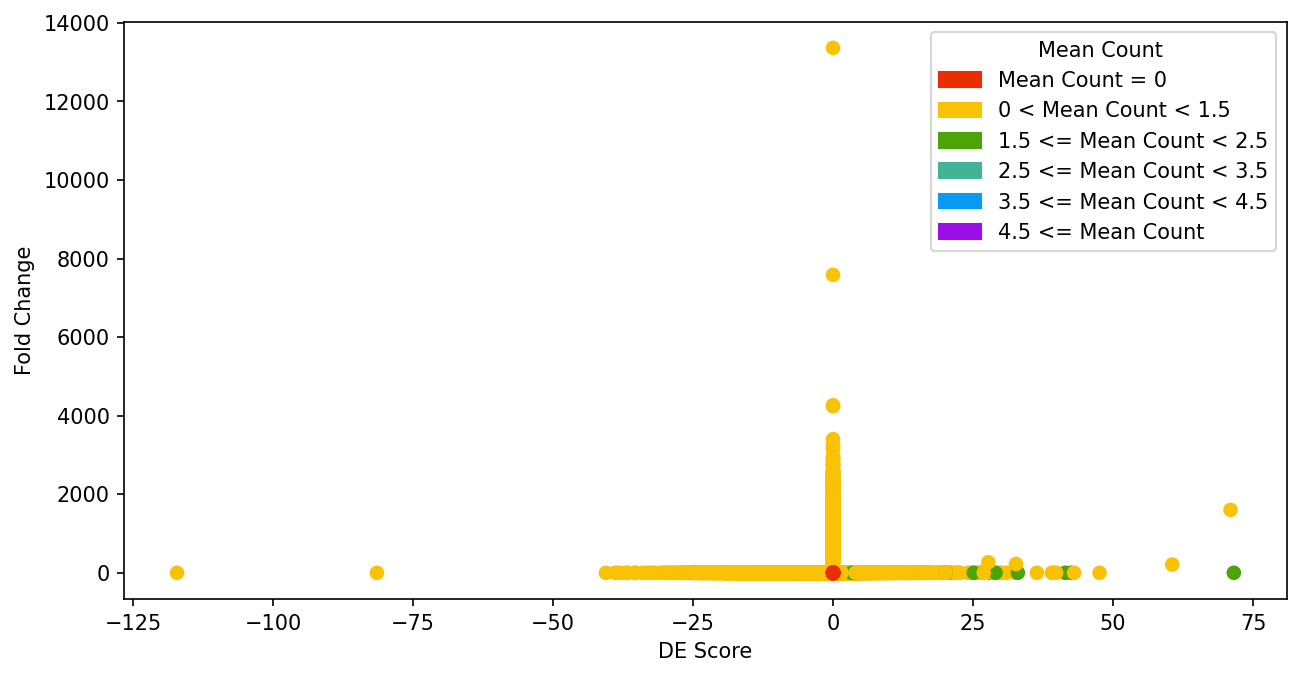

In [29]:
# fig = plt.figure(figsize=(10,5), dpi=150)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, rowspan=2)

# foldChangeLst = bioRep['Control_7_VC24L_9_VC23L']
# DEvsFoldChangeScatter(yuh, foldChangeLst, ax1)